## CS310 Natural Language Processing
## Assignment 3. Recurrent Neural Networks for Language Modeling 

**Total points**: 

In this assignment, you will train a LSTM-based language model on the Harry Potter text data. 

### 0. Import Necessary Libraries

In [22]:
import sys

print(sys.executable)  # 输出当前内核的 Python 解释器路径

/mnt/lijl/anaconda3/envs/nnUnet/bin/python


In [23]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
# nltk.download('punkt_tab')  # 只需运行一次
from collections import Counter
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# load in TXT
HarryPotterURL = 'Harry_Potter_all_books_preprocessed.txt'
with open(HarryPotterURL, 'r', encoding='utf-8') as file:
    text = file.read()
print(text[:500])

THE BOY WHO LIVED Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you very much .They were the last people youd expect to be involved in anything strange or mysterious because they just didnt hold with such nonsense .Mr Dursley was the director of a firm called Grunnings which made drills .He was a big beefy man with hardly any neck although he did have a very large mustache .Mrs Dursley was thin and blonde and had nearly twice the usual amo


In [25]:
## 分词
tokens = word_tokenize(text)
# 词频
counter = Counter(tokens)
# 构建 word2id 词表，并加入特殊 token
word2id = {'<pad>': 0, '<unk>': 1}
for i, word in enumerate(counter.keys(), start=2):
    word2id[word] = i
# 构建 id2word 词表
id2word = {idx: word for word, idx in word2id.items()}
# 转换为 ID 序列
token_ids = [word2id.get(word, word2id['<unk>']) for word in tokens]
# 测试输出
print("Word2id: Total vocabulary = " + str(len(word2id)))
print(word2id["THE"], word2id["Harry"])
print(id2word[0], id2word[1], id2word[2])

Word2id: Total vocabulary = 30248
2 429
<pad> <unk> THE


In [26]:
class LanguageModelingDataset(torch.utils.data.Dataset):
    def __init__(self, data, block_size):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.block_size]
        y = self.data[idx + 1: idx + self.block_size + 1]
        return x, y


# 转换成 LongTensor
data_tensor = torch.tensor(token_ids, dtype=torch.long)

# 划分 train set和 test set
train_ratio = 0.9
train_len = int(train_ratio * len(data_tensor))
train_data = data_tensor[:train_len]
test_data = data_tensor[train_len:]

# 构建tensor
block_size = 64
batch_size = 32
train_dataset = LanguageModelingDataset(train_data, block_size)
test_dataset = LanguageModelingDataset(test_data, block_size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

### 1. Build the Model

In [27]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=50, hidden_dim=100, num_layers=1, bidirectional=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)

        output_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Linear(output_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        logits = self.fc(out)
        log_probs = torch.log_softmax(logits, dim=-1)
        return log_probs, hidden


### 2. Train and Evaluate

In [28]:
def train_model(model, dataloader, optimizer, criterion, epochs, device):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        total_loss = 0
        for X, Y in tqdm(dataloader):
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad()
            outputs, _ = model(X)
            loss = criterion(outputs.view(-1, outputs.size(-1)), Y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch + 1} | Avg Loss: {avg_loss:.4f}")
    return loss_history

In [29]:
def evaluate_model(model, dataloader, criterion, device="cpu"):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            outputs, _ = model(X)
            loss = criterion(outputs.view(-1, outputs.size(-1)), Y.view(-1))
            total_loss += loss.item()
    ppl = math.exp(total_loss / len(dataloader))
    print(f"Perplexity: {ppl:.2f}")
    return ppl


In [54]:
def clean_prefix(prefix, word2id):
    # 清理 prefix 中的 <unk> 标签，直接删除它们
    tokens = prefix.lower().split()
    cleaned_tokens = [token for token in tokens if word2id.get(token) is not None]  # 仅保留词汇表中存在的单词
    return ' '.join(cleaned_tokens)

def generate_greedy(model, word2id, id2word, prefix, max_len=20, device="cpu"):
    model.eval()

    # 清理 prefix，去除 <unk> 标签
    cleaned_prefix = clean_prefix(prefix, word2id)
    tokens = cleaned_prefix.lower().split()
    
    # 生成 initial input_ids (确保每个词都在词汇表中)
    input_ids = [word2id.get(w, word2id["<unk>"]) for w in tokens]
    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)

    hidden = None
    generated_tokens = []  # 用于保存生成的 tokens（不重复）

    with torch.no_grad():
        for _ in range(max_len):
            # 当前生成的 token 是基于 input_tensor 的最新内容进行生成的
            output, hidden = model(input_tensor, hidden)
            last_token_logits = output[:, -1, :]  # 取最后一个位置的输出
            next_token = torch.argmax(last_token_logits, dim=-1).item()

            # 将新生成的 token 加入 generated_tokens
            generated_tokens.append(next_token)
            
            # 将新生成的 token 拼接到 input_tensor 中用于下一步生成
            input_tensor = torch.cat([input_tensor, torch.tensor([[next_token]], device=device)], dim=1)

    # 拼接生成的结果并返回
    result = ' '.join([id2word.get(idx, "<unk>") for idx in generated_tokens])
    return result


In [31]:
# 初始化模型
vocab_size = len(word2id)
lstm_model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embed_dim=50,
    hidden_dim=100,
    num_layers=1,
    bidirectional=False)

# 准备训练工具
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = lstm_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.003) 

# 启动训练
print("Training LSTM...")
lstm_loss_history = train_model(lstm_model, train_loader, optimizer_lstm, criterion, epochs=7, device=device)

# 评估模型（Perplexity）
print("Evaluating LSTM...")
lstm_ppl = evaluate_model(lstm_model, test_loader, criterion, device=device)


Training LSTM...


100%|██████████| 31103/31103 [08:11<00:00, 63.34it/s]


Epoch 1 | Avg Loss: 4.2162


100%|██████████| 31103/31103 [08:08<00:00, 63.67it/s]


Epoch 2 | Avg Loss: 3.6147


100%|██████████| 31103/31103 [08:07<00:00, 63.85it/s]


Epoch 3 | Avg Loss: 3.5118


100%|██████████| 31103/31103 [08:05<00:00, 64.01it/s]


Epoch 4 | Avg Loss: 3.4710


100%|██████████| 31103/31103 [08:06<00:00, 63.87it/s]


Epoch 5 | Avg Loss: 3.4493


100%|██████████| 31103/31103 [08:05<00:00, 64.06it/s]


Epoch 6 | Avg Loss: 3.4358


100%|██████████| 31103/31103 [08:05<00:00, 64.08it/s]


Epoch 7 | Avg Loss: 3.4257
Evaluating LSTM...
Perplexity: 31655.46


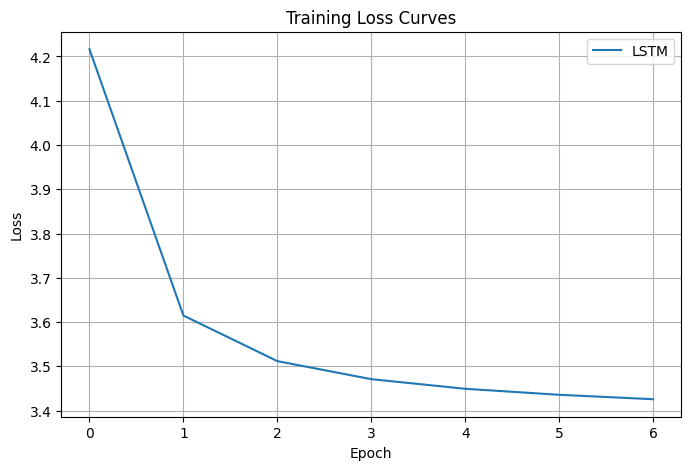

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(lstm_loss_history, label="LSTM")
plt.title("Training Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(len(lstm_loss_history)))

plt.legend()
plt.grid(True)
plt.show()


In [33]:
prefix = "Harry looked at"
print(f"\nGenerated sentences from prefix: '{prefix}'\n")

for i in range(5):
    lstm_output = generate_greedy(lstm_model, word2id, id2word, prefix, max_len=20, device=device)

    print(f"Pair {i + 1}:")
    print("  LSTM: ", lstm_output)


Generated sentences from prefix: 'Harry looked at'

Pair 1:
  LSTM:  <unk> looked at him at once .They were all bleating about silencing you somehow discrediting you but I daresay we shall be able
Pair 2:
  LSTM:  <unk> looked at him at once .They were all bleating about silencing you somehow discrediting you but I daresay we shall be able
Pair 3:
  LSTM:  <unk> looked at him at once .They were all bleating about silencing you somehow discrediting you but I daresay we shall be able
Pair 4:
  LSTM:  <unk> looked at him at once .They were all bleating about silencing you somehow discrediting you but I daresay we shall be able
Pair 5:
  LSTM:  <unk> looked at him at once .They were all bleating about silencing you somehow discrediting you but I daresay we shall be able


In [55]:
prefixes = [
    "Harry looked at",
    "Harry looked over",
    "Hermione said that",
    "Ron said",
    "The wand flied",
    "Dumbledore rushed out the room angrily"
]

for prefix in prefixes:
    print(f"{prefix} {generate_greedy(lstm_model, word2id, id2word, prefix, max_len=50, device=device)}")

Harry looked at him and he launched himself away and the toes of the sensation that he had never had Ministerial ambitions .Three years ago and the essential thing to do with the prophecy would consent to remove the Permanent Sticking Charm that keeps admitting that he was likely to collect him to
Harry looked over his shoulder .Somebody was plainly not to be dreaming about dueling it was a week look at the Firebolt and he saw him glance at him and looked up at the ceiling of the Pensieve .There were a few seconds as he had to get to the Burrow .He was
Hermione said that he was looking at him and he was going to be married said Ron and Hermione together together soundlessly .Everything was in a corner of the closet .Harry and Ron were looking at him and looked up at the ceiling of the Pensieve .There were a few seconds as he
Ron said Ron looking uneasily at the sound of the operation he had been dreading the Snitch that he had to get back to the ground .He was not sure that the Mufflia

Compare with pretrained embeddings

In [34]:
import gensim.downloader as api

# 下载 GloVe（200维）预训练词向量
glove = api.load("glove-wiki-gigaword-200")
embedding_dim = 200
hidden_dim=256
vocab_size = len(word2id)
# 初始化：每个词都是全 0
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in word2id.items():
    if word in glove:
        embedding_matrix[idx] = glove[word]
    else:
        # 没找到的词用随机初始化（或均值、全零）
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

pretrained_tensor = torch.tensor(embedding_matrix, dtype=torch.float)

lstm_pretrained = LSTMLanguageModel(
    vocab_size=vocab_size,
    embed_dim=embedding_dim,  #200,
    hidden_dim=hidden_dim,  #256,
    num_layers=1
)

# 替换 embedding 权重
lstm_pretrained.embedding = nn.Embedding.from_pretrained(pretrained_tensor, freeze=False)   
lstm_pretrained = lstm_pretrained.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_lstm_gensim_glove = torch.optim.Adam(lstm_pretrained.parameters(), lr=0.0005)

print("Training GloVe pretrained LSTM...")
loss_pretrained = train_model(lstm_pretrained, train_loader, optimizer_lstm_gensim_glove, criterion, epochs=10,
                              device=device)

Training GloVe pretrained LSTM...


100%|██████████| 31103/31103 [13:09<00:00, 39.38it/s]


Epoch 1 | Avg Loss: 4.2830


100%|██████████| 31103/31103 [13:07<00:00, 39.49it/s]


Epoch 2 | Avg Loss: 2.9579


100%|██████████| 31103/31103 [13:03<00:00, 39.72it/s]


Epoch 3 | Avg Loss: 2.3696


100%|██████████| 31103/31103 [17:54<00:00, 28.96it/s]


Epoch 4 | Avg Loss: 2.0439


100%|██████████| 31103/31103 [17:33<00:00, 29.51it/s]


Epoch 5 | Avg Loss: 1.8557


100%|██████████| 31103/31103 [23:22<00:00, 22.18it/s]


Epoch 6 | Avg Loss: 1.7403


100%|██████████| 31103/31103 [21:23<00:00, 24.23it/s]


Epoch 7 | Avg Loss: 1.6643


100%|██████████| 31103/31103 [13:12<00:00, 39.26it/s]


Epoch 8 | Avg Loss: 1.6109


100%|██████████| 31103/31103 [12:50<00:00, 40.36it/s]


Epoch 9 | Avg Loss: 1.5711


100%|██████████| 31103/31103 [12:45<00:00, 40.62it/s]

Epoch 10 | Avg Loss: 1.5403


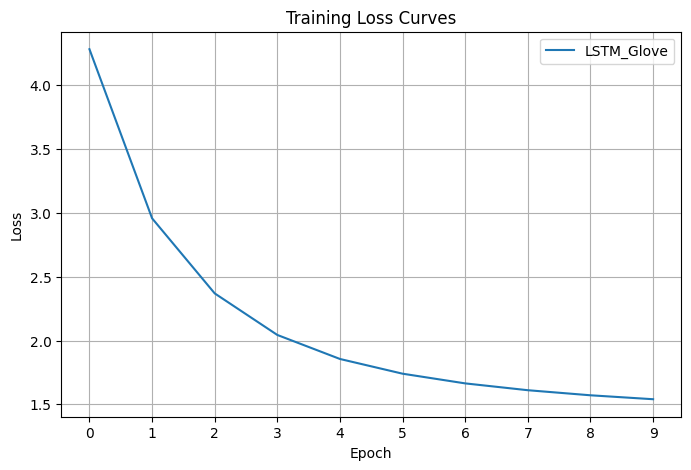

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(loss_pretrained, label="LSTM_Glove")
plt.title("Training Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(len(loss_pretrained)))
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# 评估模型（Perplexity）
print("Evaluating LSTM with Glove...")
lstm_glove_ppl = evaluate_model(lstm_pretrained, test_loader, criterion, device=device)

Evaluating LSTM with Glove...
Perplexity: 85965.09


In [37]:
prefix = "Harry looked at"
print(f"\nGenerated sentences from prefix: '{prefix}'\n")

for i in range(5):
    lstm_glove_output = generate_greedy(lstm_pretrained, word2id, id2word, prefix, max_len=20, device=device)

    print(f"Pair {i + 1}:")
    print("  LSTM: ", lstm_glove_output)


Generated sentences from prefix: 'Harry looked at'

Pair 1:
  LSTM:  <unk> looked at him .Madam Pomfrey was actually in a cave dark .Harry and Hermione waited until they were all wearing the same
Pair 2:
  LSTM:  <unk> looked at him .Madam Pomfrey was actually in a cave dark .Harry and Hermione waited until they were all wearing the same
Pair 3:
  LSTM:  <unk> looked at him .Madam Pomfrey was actually in a cave dark .Harry and Hermione waited until they were all wearing the same
Pair 4:
  LSTM:  <unk> looked at him .Madam Pomfrey was actually in a cave dark .Harry and Hermione waited until they were all wearing the same
Pair 5:
  LSTM:  <unk> looked at him .Madam Pomfrey was actually in a cave dark .Harry and Hermione waited until they were all wearing the same


In [56]:
prefixes = [
    "Harry looked at",
    "Harry looked over",
    "Hermione said that",
    "Ron said",
    "The wand flied",
    "Dumbledore rushed out the room angrily"
]

for prefix in prefixes:
    print(f"{prefix} {generate_greedy(lstm_pretrained, word2id, id2word, prefix, max_len=50, device=device)}")

Harry looked at him as though she had not heard her say that her hand was still in the air and that it was on a hinge .Someone had obviously tried to behead him but not done it properly .Looking pleased at the stunned looks on their faces Nearly Headless Nick flipped his
Harry looked over his shoulder Harry felt as though the sunlight had dropped a red light It flew twenty minutes later with everyone else was inside a burst of flame which shot across Magnolia Crescent and settled it into a chair opposite her oddly misty eyes of tiny eyes upon him .Her eyes
Hermione said that the room was full of the smell of cats the socks that wound despite the freezing water looking sick and cried On my name what happened Dad an I couldnt do .White an shakin he was .An yeh know what yer mum and dad yer parents ? Ronan said Hagrid
Ron said Harry quickly as Ron and Hermione found Fleur and Roger Davies who had a large round of inky shadows and casting a great deal of acrid black creatures who were sitt